In [1]:
import torch.nn as nn
import torch

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, bottleneck_size):
        super().__init__()
        self.encoder=Encoder(bottleneck_size,overparam=overparam,activation=activation,bn=bn,ch=ch,input_size=input_size)
        self.decoder=Decoder(bottleneck_size,overparam=overparam,activation=activation,bn=bn,ch=ch)

    def forward(self,x):
        return self.decoder(self.encoder(x))

    def encode(self,x):
        return self.encoder(x)

    def decode(self,z):
        return self.decode(z)


import numpy as np


### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,print_partial=False):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if print_partial:
            print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.func import jvp,vmap,jacfwd


data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [122]:
print(encoder)
print(decoder)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8

In [41]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

seed=42
### Set the random seed for reproducible results
torch.manual_seed(seed)

### Initialize the two networks
d = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)


 EPOCH 1/30 	 train loss 0.08862122148275375 	 val loss 0.06523587554693222

 EPOCH 2/30 	 train loss 0.060286328196525574 	 val loss 0.05427330732345581

 EPOCH 3/30 	 train loss 0.048257920891046524 	 val loss 0.04020548239350319

 EPOCH 4/30 	 train loss 0.03572237864136696 	 val loss 0.03158273175358772

 EPOCH 5/30 	 train loss 0.02964484691619873 	 val loss 0.02736317738890648

 EPOCH 6/30 	 train loss 0.026229990646243095 	 val loss 0.024467604234814644

 EPOCH 7/30 	 train loss 0.022665638476610184 	 val loss 0.020743461325764656

 EPOCH 8/30 	 train loss 0.020062226802110672 	 val loss 0.01892019435763359

 EPOCH 9/30 	 train loss 0.018609747290611267 	 val loss 0.017747536301612854

 EPOCH 10/30 	 train loss 0.017405398190021515 	 val loss 0.01649269461631775

 EPOCH 11/30 	 train loss 0.016207799315452576 	 val loss 0.015290886163711548

 EPOCH 12/30 	 train loss 0.015106957405805588 	 val loss 0.01434903685003519

 EPOCH 13/30 	 train loss 0.014286939054727554 	 val loss 0

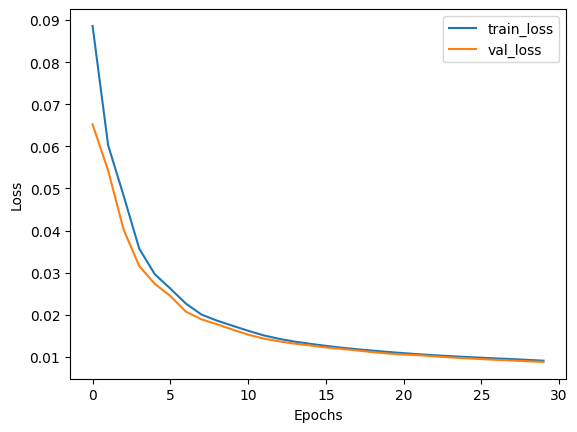

In [42]:
#%%
num_epochs = 30
npoints = 100
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =train_epoch(encoder,decoder,device,
    train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
plt.plot(diz_loss['train_loss'])
plt.plot(diz_loss['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss','val_loss'])



In [43]:
from tqdm import tqdm 
Z = []
encoder.eval()
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu()
    Z.append(encoded_img)


100%|██████████| 10000/10000 [00:03<00:00, 2786.52it/s]


### visualize two samples

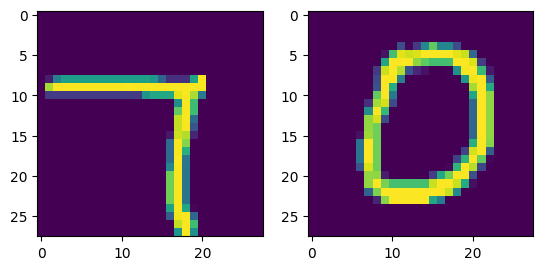

In [44]:
idx,idx2=141,10#244,5#3,0# 66,9#3, 0#1,200

plt.subplot(1,2,1)
plt.imshow(test_dataset[idx][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(test_dataset[idx2][0].permute(1,2,0))





# Compute Geodesics


In [45]:
# utilities

from torch.func import jvp,vmap,jacfwd
def energy(t,g):
    with torch.no_grad():
        step=1/t.shape[0]
        N,_=t.shape
        diff=torch.diff(g(t).reshape(N,-1),dim=0,prepend=torch.zeros((1,784),device=t.device))
        return 0.5*torch.sum((step*diff)**2)
#%%
def gradE(t,g):
    with torch.no_grad():
        N,D=t.shape
        step=1/N
        diff2=torch.diff(g(t).reshape(N,-1),dim=0,n=2,append=torch.zeros((1,784),device=t.device),prepend=torch.zeros((1,784),device=t.device))
        #J=vmap(jacfwd(g))(t.unsqueeze(-1))
        #faster
        #J=jvp(g,(t,),(torch.ones_like(t),))
        #J=J[1].reshape(N,-1)
        J=jacfwd(g)(t.cuda())
        tmp=torch.diagonal(torch.einsum('abcd,ab->acd',J.reshape(N,784,N,D),diff2),dim1=0,dim2=1).T
        return -(1/step)*tmp
        #return -(1/step)*torch.diag(J@diff2.T)
        #return  -(1/step)*J@diff2

def optimize(t,g,steps=20,alpha=0.08):
    n_step=steps//10
    with torch.no_grad():
        opt=t.detach().clone()
        results,err=[],[]
        t[0],t[-1]=opt[0],opt[-1]
        for i in range(steps):
            err.append(energy(t,g).item())
            if i%n_step==0:
                print()
                print("step ",i)
                print("Energy: ",err[i])
            if i%2==0:
                results.append(g(t))
            #plain gradient descent
            t=t-alpha*gradE(t,g)
            t[0],t[-1]=opt[0],opt[-1]
        return t,results,err
#%%
def linspace(a,b,n=10):
    ap=torch.linspace(0,1,n)
    t=[]
    for alpha in ap:
        t.append(a*(alpha)+b*(1-alpha))
    t=torch.stack(t)
    return t

import matplotlib.pyplot as plt


from sklearn.manifold import TSNE



def plot_latent_space(latent_vectors, labels):

    # Check if latent space has more than two dimensions
    if latent_vectors.shape[1] > 2:
        # Apply t-SNE to reduce dimensions to 2D
        tsne = TSNE(n_components=2, random_state=42)
        latent_vectors_2d = tsne.fit_transform(latent_vectors)
    else:
        latent_vectors_2d = latent_vectors
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the points in the latent space
    scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='viridis', s=10)


    ax.grid(True, linestyle='--', alpha=0.5)

    # Set labels and title
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.set_title('Latent Space Visualization')

    # Create a legend
    legend = ax.legend(*scatter.legend_elements(), title='Labels')
    ax.add_artist(legend)

    # Show the plot
    #plt.show()
    return fig,ax

784

In [46]:


# compute a linear path for initialization
#take the two ends as the samples we just visualized
z1,z2=Z[idx],Z[idx2]
# or set them arbitrarly in the latent space
#z1=torch.tensor([-5,-5])
#z2=torch.tensor([ -5,  2.5])
z_lin=linspace(z1,z2,20)

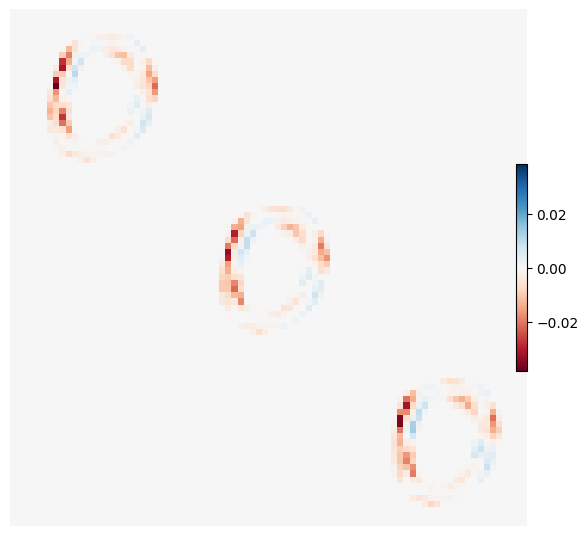

In [47]:
tmp=jacfwd(decoder)(z_lin[:3].cuda())
D=tmp.shape[-1]
view=tmp.reshape(3,28*28,3,D)[:,:,:,0].permute(0,2,1)
import matplotlib.pyplot as plt
import numpy as np


def plot_tensor_grid(tensor):
    N, _, M = tensor.shape
    image_size = int(np.sqrt(M))
    
    if image_size ** 2 != M:
        raise ValueError("M must be a perfect square.")
    
    fig, axes = plt.subplots(N, N, figsize=(N*2, N*2))
    
    # Create a common color axis
    vmin = -tensor.abs().max()
    vmax = tensor.abs().max()
    
    for i in range(N):
        for j in range(N):
            im = axes[i, j].imshow(tensor[i, j].reshape(image_size, image_size), cmap='RdBu', vmin=vmin, vmax=vmax)
            axes[i, j].axis('off')
    
    fig.tight_layout(pad=3.0)
    
    # Create a single colorbar
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()




plot_tensor_grid(view.cpu().detach())


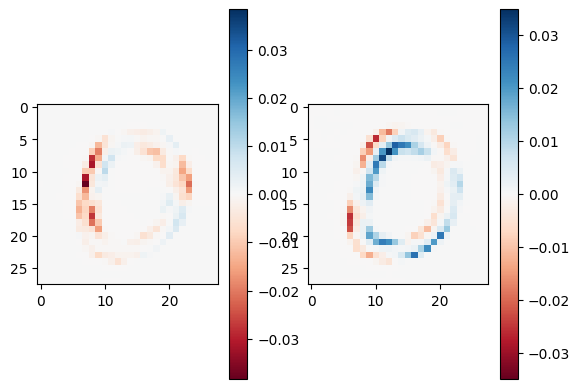

In [48]:
tmp=tmp.cpu().detach()


plt.subplot(1,2,1)
plt.imshow(tmp[0,0,:,:,0,0],cmap='RdBu')
mm=tmp[0,0,:,:,0,0].abs().max()
plt.clim(-mm,mm)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(tmp[0,0,:,:,0,1],cmap='RdBu')
mm=tmp[0,0,:,:,0,1].abs().max()
plt.clim(-mm,mm)
plt.colorbar()


step  0
Energy:  0.14340604841709137

step  500
Energy:  0.136793851852417

step  1000
Energy:  0.13399609923362732

step  1500
Energy:  0.13195747137069702

step  2000
Energy:  0.13049286603927612

step  2500
Energy:  0.12943178415298462

step  3000
Energy:  0.12859798967838287

step  3500
Energy:  0.12795716524124146

step  4000
Energy:  0.12739914655685425

step  4500
Energy:  0.12693099677562714


Text(0, 0.5, 'Geodesic energy')

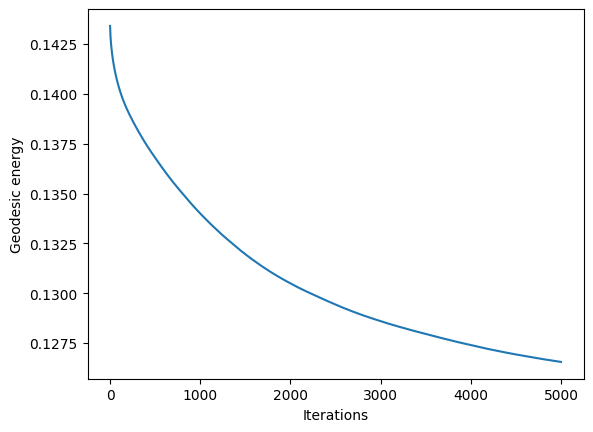

In [65]:
# optimize

alpha =5e-2#3e-5#3e-6
decoder.eval()
res,plots,err=optimize(z_lin.cuda(),decoder,steps=5000,alpha=alpha)
plt.plot(err)
plt.xlabel('Iterations')
plt.ylabel('Geodesic energy')

### plot results

Text(0.5, 1.0, 'Linear interpolation')

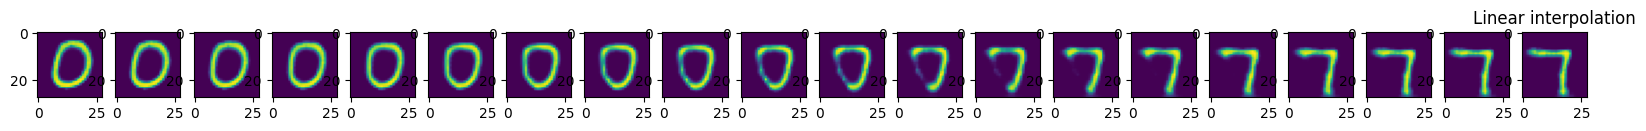

In [66]:
#plt.subplots(10,1)
plt.figure(figsize=(20,10))
dec=decoder(z_lin.cuda())
for i in range(dec.shape[0]):
    plt.subplot(1,dec.shape[0],i+1)
    plt.imshow(dec[i].detach().cpu().permute(1,2,0))
plt.title('Linear interpolation')

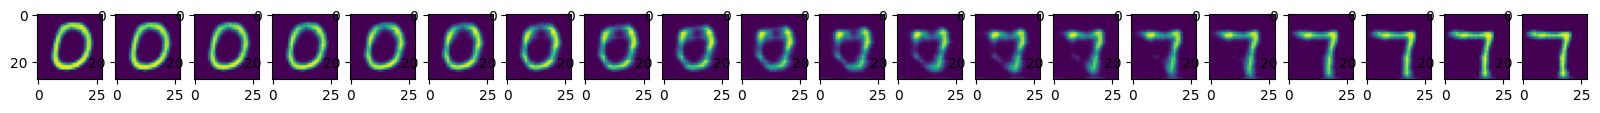

In [67]:
#geodeisc inter
plt.figure(figsize=(20,10))
dec=decoder(res.cuda())
for i in range(dec.shape[0]):
    plt.subplot(1,dec.shape[0],i+1)
    plt.imshow(dec[i].detach().cpu().permute(1,2,0))

In [58]:

res[0].device

device(type='cuda', index=0)

### visualize the geodesic in the latent space

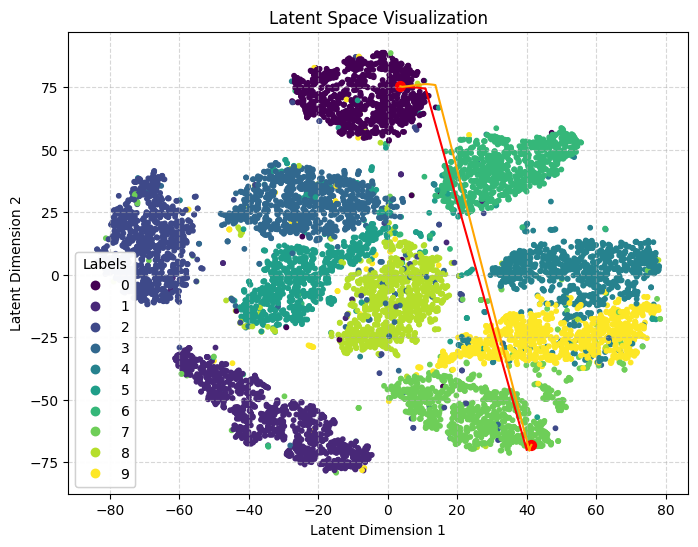

In [68]:
tsne=TSNE(n_components=2,random_state=42)
Z_all=torch.cat((torch.stack(Z),z_lin,res.cpu(),torch.stack([z1,z2])),0)
projZ=tsne.fit_transform(Z_all.cpu().detach())

S=z_lin.shape[0]
projz1=projZ[-2]#tsne.fit_transform(z1.cpu().detach().unsqueeze(0))
projz2=projZ[-1]#tsne.fit_transform(z2.cpu().detach().unsqueeze(0))
z_lin_proj=projZ[-(S*2+2):-(S+2)]
res_proj=projZ[-(S+2):-2]
projZ=projZ[:-(S*2+2)]
Y= [b[1] for b in test_dataset]
res=res.detach().cpu()
fig,ax=plot_latent_space(projZ,Y)
ax.scatter(np.stack((projz1[0],projz2[0])),np.stack((projz1[1],projz2[1])),c='r',s=50)
ax.plot(z_lin_proj[:,0],z_lin_proj[:,1],c='r')
ax.plot(res_proj[:,0],res_proj[:,1],c='orange')